# Debugging xy shift in WN regen

In [1]:
import retinanalysis as ra
import numpy as np
import matplotlib.pyplot as plt
import mat73

[2025-09-24 18:10:42,681][INFO]: DataJoint 0.14.4 connected to root@127.0.0.1:3306


In [2]:
exp_name = '20250514C'
datafile_name = 'data001'
e_idx = 9
str_mat = '/Volumes/Vyom MEA/data/noise_regen_full.mat'
d_mat = mat73.loadmat(str_mat)

In [5]:
# Clip preframes
s_frames = np.array(d_mat['frames'][16:]) / 255
s_frames.shape

(10633, 127, 203, 3)

In [9]:
import os
str_pkl = os.path.join(ra.settings.ANALYSIS_DIR, exp_name, 'chunk1', 'kilosort2.5', 'data001_sb.pkl')
# sb = ra.MEAStimBlock(exp_name, datafile_name)
# sb.export_to_pkl(str_pkl)
sb = ra.MEAStimBlock(pkl_file=str_pkl)

Initializing StimBlock for None block None from pickle file


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Vyom MEA/analysis/20250514C/chunk1/kilosort2.5/data001_sb.pkl'

StimBlock exported to /Volumes/data-1/analysis/20250514C/chunk1/kilosort2.5/data001_sb.pkl



In [7]:
sb.regenerate_stimulus(ls_epochs=[e_idx])

Regenerating stimulus for epochs: [9] in block: 3251
Using regeneration function: make_spatial_noise


  0%|          | 0/1 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
r_frames = (sb.stim_data[0]+1)/2

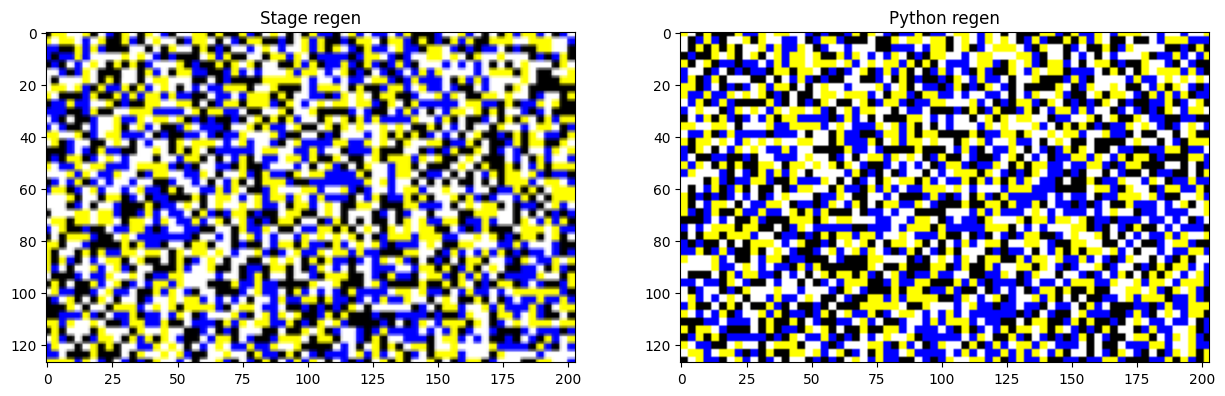

In [ ]:
f, axs = plt.subplots(ncols=2, figsize=(15,10))
ls_f = [s_frames, r_frames]
ls_titles = ['Stage regen', 'Python regen']
for i, ax in enumerate(axs):
    f = ls_f[i]
    im=ax.imshow(f[0])
    ax.set_title(ls_titles[i])
